# TensorFlow 教程 #02
# 卷积神经网络

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)/[Github](https://github.com/thrillerist/TensorFlow-Tutorials)

## 介绍

先前的教程展示了一个简单的线性模型，对MNIST数据集中手写数字的识别率达到了91%。

在这个教程中，我们会在TensorFlow中实现一个简单的卷积神经网络，它能达到大约99%的分类准确率，如果你做了一些建议的练习，准确率还可能更高。

卷积神经网络在一张输入图片上移动一个小的滤波器。这意味着在遍历整张图像来识别模式时，要重复使用这些滤波器。这让卷积神经网络在拥有相同数量的变量时比全连接网络（Fully-Connected）更强大，也让卷积神经网络训练得更快。

你应该熟悉基本的线性代数、Python和Jupyter Notebook编辑器。如果你是TensorFlow新手，在本教程之前应该先学习第一篇教程。

## 流程图

下面的图表直接显示了之后实现的卷积神经网络中数据的传递。

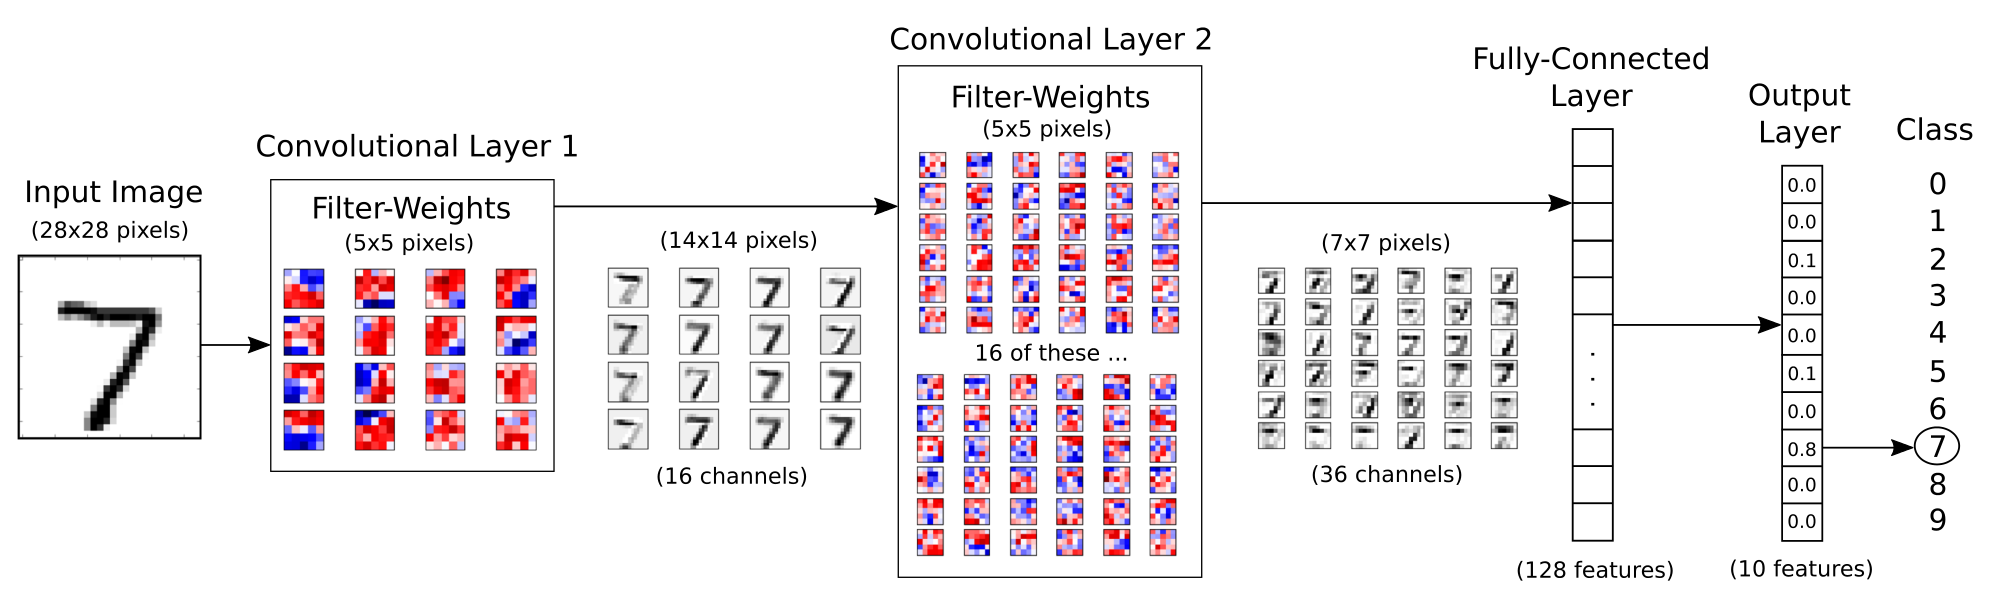

In [2]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

输入图像在第一层卷积层里使用权重过滤器处理。结果在16张新图里，每张代表了卷积层里一个过滤器（的处理结果）。图像经过降采样，分辨率从28x28减少到14x14。

16张小图在第二个卷积层中处理。这16个通道以及这层输出的每个通道都需要一个过滤权重。总共有36个输出，所以在第二个卷积层有16 x 36 = 576个滤波器。输出图再一次降采样到7x7个像素。

第二个卷积层的输出是36张7x7像素的图像。它们被转换到一个长为7 x 7 x 36 = 1764的向量中去，它作为一个有128个神经元（或元素）的全连接网络的输入。这些又输入到另一个有10个神经元的全连接层中，每个神经元代表一个类别，用来确定图像的类别，即图像上的数字。

卷积滤波一开始是随机挑选的，因此分类也是随机完成的。根据交叉熵（cross-entropy）来测量输入图预测值和真实类别间的错误。然后优化器用链式法则自动地将这个误差在卷积网络中传递，更新滤波权重来提升分类质量。这个过程迭代了几千次，直到分类误差足够低。

这些特定的滤波权重和中间图像是一个优化结果，和你执行代码所看到的可能会有所不同。

注意，这些在TensorFlow上的计算是在一部分图像上执行，而非单独的一张图，这使得计算更有效。也意味着在TensorFlow上实现时，这个流程图实际上会有更多的数据维度。


## 卷积层

下面的图片展示了在第一个卷积层中处理图像的基本思想。输入图片描绘了数字7，这里显示了它的四张拷贝，我们可以很清晰的看到滤波器是如何在图像的不同位置移动。在滤波器的每个位置上，计算滤波器以及滤波器下方图像像素的点乘，得到输出图像的一个像素。因此，在整张输入图像上移动时，会有一张新的图像生成。

红色的滤波权重表示滤波器对输入图的黑色像素有正响应，蓝色的代表有负响应。

在这个例子中，很明显这个滤波器识别数字7的水平线段，在输出图中可以看到它对线段的强烈响应。

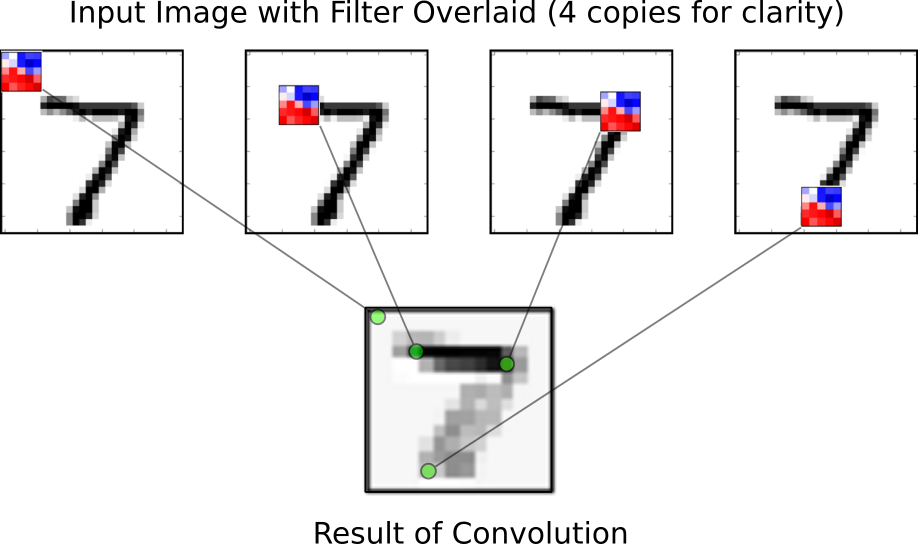

In [3]:
Image('images/02_convolution.png')

滤波器遍历输入图的移动步长称为stride。在水平和竖直方向各有一个stride。

在下面的源码中，两个方向的stride都设为1，这说明滤波器从输入图像的左上角开始，下一步移动到右边1个像素去。当滤波器到达图像的右边时，它会返回最左边，然后向下移动1个像素。持续这个过程，直到滤波器到达输入图像的右下角，同时，也生成了整张输出图片。

当滤波器到达输入图的右端或底部时，它会用零（白色像素）来填充。因为输出图要和输入图一样大。

此外，卷积层的输出可能会传递给修正线性单元（ReLU），它用来保证输出是正值，将负值置为零。输出还会用最大池化(max-pooling)进行降采样，它使用了2x2的小窗口，只保留像素中的最大值。这让输入图分辨率减小一半，比如从28x28到14x14。

第二个卷积层更加复杂，因为它有16个输入通道。我们想给每个通道一个单独的滤波，因此需要16个。另外，我们想从第二个卷积层得到36个输出，因此总共需要16 x 36 = 576个滤波器。要理解这些如何工作可能有些困难。

## 导入

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [5]:
tf.__version__

'1.6.0'

## 神经网络的配置

方便起见，在这里定义神经网络的配置，你可以很容易找到或改变这些数值，然后重新运行Notebook。

In [6]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## 载入数据

MNIST数据集大约12MB，如果没在文件夹中找到就会自动下载。

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


现在已经载入了MNIST数据集，它由70,000张图像和对应的标签（比如图像的类别）组成。数据集分成三份互相独立的子集。我们在教程中只用训练集和测试集。

In [8]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


类型标签使用One-Hot编码，这意外每个标签是长为10的向量，除了一个元素之外，其他的都为零。这个元素的索引就是类别的数字，即相应图片中画的数字。我们也需要测试数据集类别数字的整型值，用下面的方法来计算。

In [9]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## 数据维度

在下面的源码中，有很多地方用到了数据维度。它们只在一个地方定义，因此我们可以在代码中使用这些数字而不是直接写数字。

In [10]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 用来绘制图片的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    # if not true, raise an error
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制几张图像来看看数据是否正确

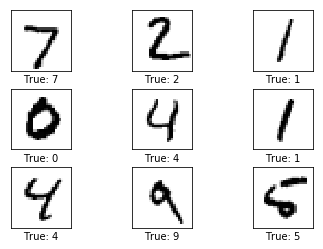

In [12]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow图

TensorFlow的全部目的就是使用一个称之为计算图（computational graph）的东西，它会比直接在Python中进行相同计算量要高效得多。TensorFlow比Numpy更高效，因为TensorFlow了解整个需要运行的计算图，然而Numpy只知道某个时间点上唯一的数学运算。

TensorFlow也能够自动地计算需要优化的变量的梯度，使得模型有更好的表现。这是由于图是简单数学表达式的结合，因此整个图的梯度可以用链式法则推导出来。

TensorFlow还能利用多核CPU和GPU，Google也为TensorFlow制造了称为TPUs（Tensor Processing Units）的特殊芯片，它比GPU更快。

一个TensorFlow图由下面几个部分组成，后面会详细描述：

* 占位符变量（Placeholder）用来改变图的输入。
* 模型变量（Model）将会被优化，使得模型表现得更好。
* 模型本质上就是一些数学函数，它根据Placeholder和模型的输入变量来计算一些输出。
* 一个cost度量用来指导变量的优化。
* 一个优化策略会更新模型的变量。

另外，TensorFlow图也包含了一些调试状态，比如用TensorBoard打印log数据，本教程不涉及这些。

### Helper-functions for creating new variables

### 创建新变量的帮助函数

函数用来根据给定大小创建TensorFlow变量，并将它们用随机值初始化。需注意的是在此时并未完成初始化工作，仅仅是在TensorFlow图里定义它们。

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [14]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### 创建卷积层的帮助函数

这个函数为TensorFlow在计算图里创建了新的卷积层。这里并没有执行什么计算，只是在TensorFlow图里添加了数学公式。

假设输入的是四维的张量，各个维度如下：

1. 图像数量
2. 每张图像的Y轴
3. 每张图像的X轴
4. 每张图像的通道数

输入通道可能是彩色通道，当输入是前面的卷积层生成的时候，它也可能是滤波通道。

输出是另外一个4通道的张量，如下：

1. 图像数量，与输入相同
2. 每张图像的Y轴。如果用到了2x2的池化，是输入图像宽高的一半。
3. 每张图像的X轴。同上。
4. 卷积滤波生成的通道数。

In [15]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### 转换一个层的帮助函数

卷积层生成了4维的张量。我们会在卷积层之后添加一个全连接层，因此我们需要将这个4维的张量转换成可被全连接层使用的2维张量。

In [16]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### 创建一个全连接层的帮助函数

这个函数为TensorFlow在计算图中创建了一个全连接层。这里也不进行任何计算，只是往TensorFlow图中添加数学公式。

输入是大小为`[num_images, num_inputs]`的二维张量。输出是大小为`[num_images, num_outputs]`的2维张量。

In [17]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，每次我们运行图的时候都可能会改变它们。将这个过程称为feeding placeholder变量，后面将会描述它。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为float32，形状设为`[None, img_size_flat]`，`None`代表tensor可能保存着任意数量的图像，每张图象是一个长度为`img_size_flat`的向量。

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

卷积层希望`x`被编码为4维张量，因此我们需要将它的形状转换至`[num_images, img_height, img_width, num_channels]`。注意`img_height == img_width == img_size`，如果第一维的大小设为-1， `num_images`的大小也会被自动推导出来。转换运算如下：

In [19]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

接下来我们为输入变量`x`中的图像所对应的真实标签定义placeholder变量。变量的形状是`[None, num_classes]`，这代表着它保存了任意数量的标签，每个标签是长度为`num_classes`的向量，本例中长度为10。

In [20]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

我们也可以为class-number提供一个placeholder，但这里用argmax来计算它。这里只是TensorFlow中的一些操作，没有执行什么运算。


In [21]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### 卷积层 1

创建第一个卷积层。将`x_image`当作输入，创建`num_filters1`个不同的滤波器，每个滤波器的宽高都与 `filter_size1`相等。最终我们会用2x2的max-pooling将图像降采样，使它的尺寸减半。

In [22]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

检查卷积层输出张量的大小。它是（？,14, 14, 16），这代表着有任意数量的图像（？代表数量），每张图像有14个像素的宽和高，有16个不同的通道，每个滤波器各有一个通道。

In [23]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### 卷积层 2

创建第二个卷积层，它将第一个卷积层的输出作为输入。输入通道的数量对应着第一个卷积层的滤波数。

In [24]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

核对一下这个卷积层输出张量的大小。它的大小是（？， 7， 7， 36）,其中？也代表着任意数量的图像，每张图有7像素的宽高，每个滤波器有36个通道。

In [25]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### 转换层

这个卷积层输出一个4维张量。现在我们想将它作为一个全连接网络的输入，这就需要将它转换成2维张量。

In [26]:
layer_flat, num_features = flatten_layer(layer_conv2)

这个张量的大小是（？， 1764），意味着共有一定数量的图像，每张图像被转换成长为1764的向量。其中1764 = 7 x 7 x 36。

In [27]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [28]:
num_features

1764

### 全连接层 1

往网络中添加一个全连接层。输入是一个前面卷积得到的被转换过的层。全连接层中的神经元或节点数为`fc_size`。我们可以用ReLU来学习非线性关系。

In [29]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

全连接层的输出是一个大小为（？，128）的张量，？代表着一定数量的图像，并且`fc_size` == 128。

In [30]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### 全连接层 2

添加另外一个全连接层，它的输出是一个长度为10的向量，它确定了输入图是属于哪个类别。这层并没有用到ReLU。

In [31]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [32]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### 预测类别

第二个全连接层估算了输入图有多大的可能属于10个类别中的其中一个。然而，这是很粗略的估计并且很难解释，因为数值可能很小或很大，因此我们会对它们做归一化，将每个元素限制在0到1之间，并且相加为1。这用一个称为softmax的函数来计算的，结果保存在`y_pred`中。

In [33]:
y_pred = tf.nn.softmax(layer_fc2)

类别数字是最大元素的索引。

In [34]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### 优化损失函数

为了使模型更好地对输入图像进行分类，我们必须改变`weights`和`biases`变量。首先我们需要对比模型`y_pred`的预测输出和期望输出的`y_true`，来了解目前模型的性能如何。

交叉熵（cross-entropy）是在分类中使用的性能度量。交叉熵是一个常为正值的连续函数，如果模型的预测值精准地符合期望的输出，它就等于零。因此，优化的目的就是通过改变网络层的变量来最小化交叉熵。

TensorFlow有一个内置的计算交叉熵的函数。这个函数内部计算了softmax，所以我们要用`layer_fc2`的输出而非直接用`y_pred`,因为`y_pred`上已经计算了softmax。

In [35]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



我们为每个图像分类计算了交叉熵，所以有一个当前模型在每张图上表现的度量。但是为了用交叉熵来指导模型变量的优化，我们需要一个额外的标量值，因此简单地利用所有图像分类交叉熵的均值。

In [36]:
cost = tf.reduce_mean(cross_entropy)

### 优化方法

既然我们有一个需要被最小化的损失度量，接着就可以建立优化一个优化器。这个例子中，我们使用的是梯度下降的变体`AdamOptimizer`。

优化过程并不是在这里执行。实际上，还没计算任何东西，我们只是往TensorFlow图中添加了优化器，以便之后的操作。

In [37]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### 性能度量

我们需要另外一些性能度量，来向用户展示这个过程。

这是一个布尔值向量，代表预测类型是否等于每张图片的真实类型。

In [38]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

上面的计算先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [39]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [40]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf.Session(config=config)

### 初始化变量

我们需要在开始优化weights和biases变量之前对它们进行初始化。

In [41]:
session.run(tf.global_variables_initializer())

### 用来优化迭代的帮助函数

在训练集中有50,000张图。用这些图像计算模型的梯度会花很多时间。因此我们利用随机梯度下降的方法，它在优化器的每次迭代里只用到了一小部分的图像。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [42]:
train_batch_size = 64

函数执行了多次的优化迭代来逐步地提升网络层的变量。在每次迭代中，从训练集中选择一批新的数据，然后TensorFlow用这些训练样本来执行优化器。每100次迭代会打印出相关信息。

In [43]:
# Counter for total number of iterations performed so far.
total_iterations = 256

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 用来绘制错误样本的帮助函数

函数用来绘制测试集中被误分类的样本。

In [44]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 绘制混淆（confusion）矩阵的帮助函数

In [45]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 展示性能的帮助函数

函数用来打印测试集上的分类准确度。

为测试集上的所有图片计算分类会花费一段时间，因此我们直接用这个函数来调用上面的结果，这样就不用每次都重新计算了。

这个函数可能会占用很多电脑内存，这也是为什么将测试集分成更小的几个部分。如果你的电脑内存比较小或死机了，就要试着降低batch-size。

In [46]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## 优化之前的性能

测试集上的准确度很低，这是由于模型只做了初始化，并没做任何优化，所以它只是对图像做随机分类。


In [47]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (983 / 10000)


## 1次迭代后的性能

做了一次优化后，此时优化器的学习率很低，性能其实并没有多大提升。

In [48]:
optimize(num_iterations=1)

Time usage: 0:00:00


In [49]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (983 / 10000)


## 100次迭代优化后的性能

100次优化迭代之后，模型显著地提升了分类的准确度。

In [50]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Optimization Iteration:    301, Training Accuracy:  26.6%
Time usage: 0:00:01


Accuracy on Test-Set: 65.4% (6538 / 10000)
Example errors:


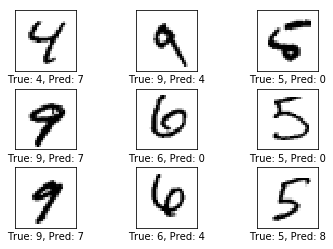

In [51]:
print_test_accuracy(show_example_errors=True)

## 1000次优化迭代后的性能

1000次优化迭代之后，模型在测试集上的准确度超过了90%。

In [52]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    401, Training Accuracy:  71.9%
Optimization Iteration:    501, Training Accuracy:  85.9%
Optimization Iteration:    601, Training Accuracy:  85.9%
Optimization Iteration:    701, Training Accuracy:  85.9%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  96.9%
Optimization Iteration:   1001, Training Accuracy:  92.2%
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Time usage: 0:00:06


Accuracy on Test-Set: 92.4% (9238 / 10000)
Example errors:


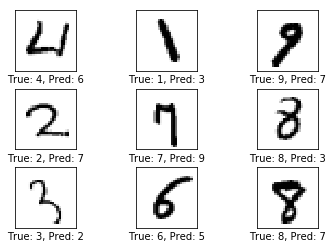

In [53]:
print_test_accuracy(show_example_errors=True)

## 10,000次优化迭代后的性能

经过10,000次优化迭代后，测试集上的分类准确率高达99%。

In [54]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  90.6%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  90.6%
Optimization Iteration:   2201, Training Accuracy:  93.8%
Optimization Iteration:   2301, Training Accuracy:  93.8%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  95.3%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization Iteration:   2701, Training Accuracy:  95.3%
Optimization Iteration:   2801, Training Accuracy: 100.0%
Optimization Iteration:   2901, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 98.7% (9865 / 10000)
Example errors:


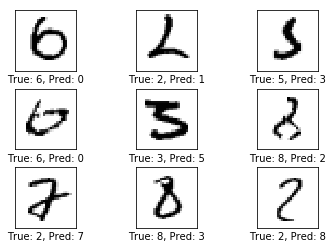

Confusion Matrix:
[[ 974    0    1    0    0    0    1    1    2    1]
 [   0 1124    4    0    0    1    1    1    4    0]
 [   2    2 1016    1    1    0    0    2    8    0]
 [   1    0    1 1001    0    3    0    0    2    2]
 [   0    0    0    0  973    0    1    0    3    5]
 [   2    0    0    6    0  882    1    0    0    1]
 [   7    2    0    0    5    6  936    0    2    0]
 [   0    2    7    2    0    0    0 1011    2    4]
 [   4    0    3    4    1    2    0    2  955    3]
 [   2    4    0    2    5    2    0    1    0  993]]


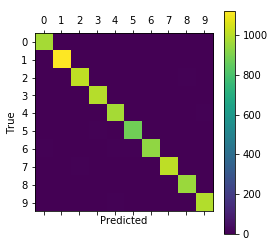

In [55]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## 权重和层的可视化

为了理解为什么卷积神经网络可以识别手写数字，我们将会对卷积滤波和输出图像进行可视化。

### 绘制卷积权重的帮助函数

In [56]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制卷积层输出的帮助函数

In [57]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 输入图像

绘制图像的帮助函数

In [58]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

如下所示，绘制一张测试集中的图像。

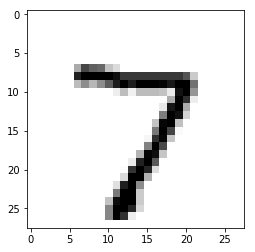

In [59]:
image1 = data.test.images[0]
plot_image(image1)

绘制测试集里的另一张图像。

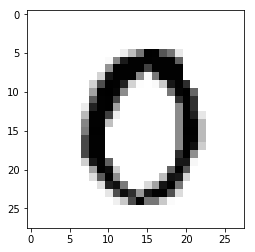

In [60]:
image2 = data.test.images[13]
plot_image(image2)

### 卷积层 1

现在绘制第一个卷积层的滤波权重。

其中正值权重是红色的，负值为蓝色。

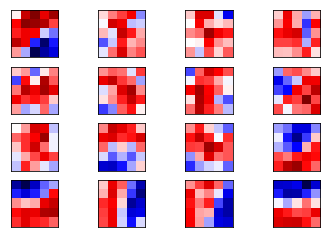

In [61]:
plot_conv_weights(weights=weights_conv1)

将这些卷积滤波添加到第一张输入图像，得到以下输出，它们也作为第二个卷积层的输入。注意这些图像被降采样到14 x 14像素，即原始输入图分辨率的一半。

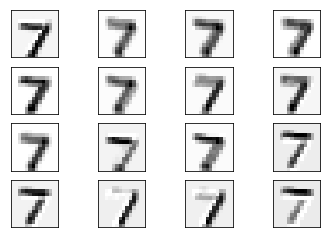

In [62]:
plot_conv_layer(layer=layer_conv1, image=image1)

下面是将卷积滤波添加到第二张图像的结果。

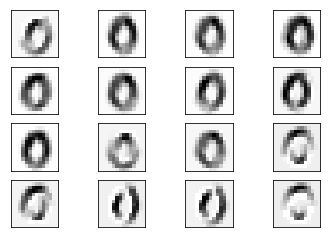

In [63]:
plot_conv_layer(layer=layer_conv1, image=image2)

从这些图像很难看出卷积滤波的作用是什么。显然，它们生成了输入图像的一些变体，就像光线从不同角度打到图像上并产生阴影一样。

### 卷积层 2

现在绘制第二个卷积层的滤波权重。

第一个卷积层有16个输出通道，代表着第二个卷基层有16个输入。第二个卷积层的每个输入通道也有一些权重滤波。我们先绘制第一个通道的权重滤波。

同样的，正值是红色，负值是蓝色。

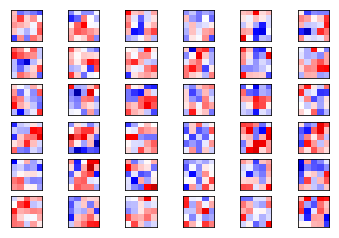

In [64]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

第二个卷积层共有16个输入通道，我们可以同样地画出其他图像。这里我们画出第二个通道的图像。

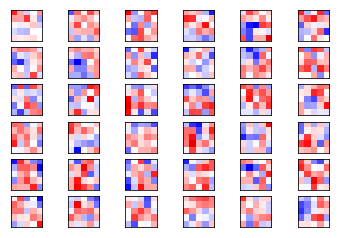

In [65]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

由于这些滤波是高维度的，很难理解它们是如何应用的。

给第一个卷积层的输出加上这些滤波，得到下面的图像。

这些图像被降采样至7 x 7的像素，即上一个卷积层输出的一半。

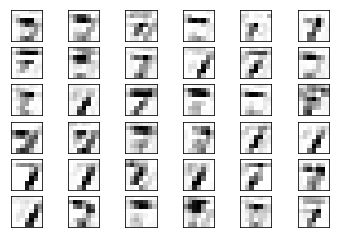

In [66]:
plot_conv_layer(layer=layer_conv2, image=image1)

这是给第二张图像加上滤波权重的结果。

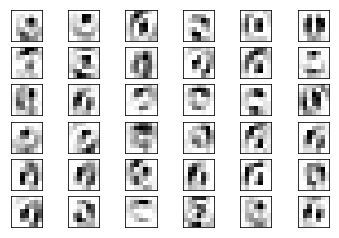

In [67]:
plot_conv_layer(layer=layer_conv2, image=image2)

从这些图像来看，似乎第二个卷积层会检测输入图像中的线段和模式，这对输入图中的局部变化不那么敏感。

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


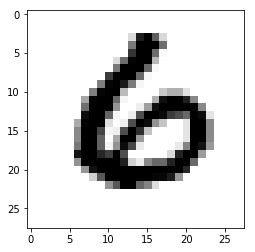

NN predicted 6


In [68]:
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)
# code to use your own picture as input x
# from PIL import Image
# import numpy as np
# img = np.array(Image.open('test3.bmp'))

## code to use random pictures from mnist as input x
from random import randint
num = randint(0, mnist.test.images.shape[0])
img = mnist.test.images[num]

# code to display the picture
from matplotlib import pyplot as plt
img = img.reshape(1, 784)
plt.imshow(img.reshape(28, 28), cmap=plt.cm.binary)
plt.show()

# finally feed the image and get the prediction
feed_dict = {x: img}
y_pred = session.run(tf.argmax(y_pred, 1), feed_dict=feed_dict)
print('NN predicted', y_pred[0])

### 关闭TensorFlow会话

现在我们已经用TensorFlow完成了任务，关闭session，释放资源。

In [69]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()

## 总结

我们看到卷积神经网络在识别手写数字上的表现要比教程#01中简单线性模型要好得多。卷积神经网络可能达到99%的分类准确率，如果你做一些调整，还可能表现得更好，而简单线性模型只有91%的正确率。

然而，卷积神经网络实现起来更复杂，并且光看权重滤波也不好理解为什么它能奏效或者失败。

因此我们需要一个更简单的实现卷积神经网络的方式，同时也要寻找一种更好的方法来对它们内部工作原理进行可视化。

## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 如果你不改变任何参数，多次运行Notebook，会得到完成一样的结果吗？随机性的来源是什么？

* 再进行10,000次优化。结果有变好么？

* 改变优化器的学习率。

* 改变层次的属性，比如卷积滤波器数量、滤波器的大小、全连接层中的神经元数量等等。

* 在全连接层之后添加一个drop-out层。在计算分类准确率的时候，drop-out层可能为0，因此你需要一个placeholder变量。

* 改变ReLU和max-pooling的顺序。它的计算结果相同么？最快的计算方法是什么？节省了多少计算量？这也适用于Sigmoid-function和average-pooling吗？

* 添加一个或多个卷积层和全连接层。这对性能有帮助吗？

* 能得到良好结果的最小可能配置是什么？

* 试着在最后一个全连接层中使用ReLU。性能有变化吗？为什么？

* 卷积层里不用pooling。这对分类准确率和训练时间有影响吗？

* 在卷积层里用2x2的stride代替max-pooling？有什么变化吗？

* 不看源码，自己重写程序。

* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.